In [1]:
import comet_ml
from comet_ml import API
from comet_ml import Experiment

experiment = Experiment('HU8yNOX96Ang8huavKsvrTbiK', project_name="diff_sim_ffjord", workspace="schattengenie")

COMET INFO: old comet version (1.0.54) detected. current: 1.0.55 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/schattengenie/diff-sim-ffjord/f94defd885c447569cb45b2e857a5b22



In [39]:
from model import YModel, R

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
import pandas as pd
from tqdm import trange
%pylab inline

import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('./simple_surr.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

## Recovering conditional density with FFJORD

# All needed imports

In [4]:
device = torch.device('cuda:0')

In [5]:
# !pip install git+https://github.com/rtqichen/torchdiffeq.git

In [6]:
import sys
import torch
import torch.optim as optim
from IPython.display import clear_output

sys.path.append('./ffjord/')
import ffjord.lib.utils as utils
from ffjord.lib.visualize_flow import visualize_transform
import ffjord.lib.layers.odefunc as odefunc
from ffjord.train_misc import standard_normal_logprob
from ffjord.train_misc import count_nfe, count_parameters, count_total_time
from ffjord.train_misc import add_spectral_norm, spectral_norm_power_iteration
from ffjord.train_misc import create_regularization_fns, get_regularization, append_regularization_to_log
from ffjord.train_misc import build_model_tabular
import lib.layers as layers

In [7]:
SOLVERS = ["dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams']

print(odefunc.NONLINEARITIES)

{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


In [8]:
def set_cnf_options(model, solver, rademacher, residual, atol=1e-5, rtol=1e-5):

    def _set(module):
        if isinstance(module, layers.CNF):
            # Set training settings
            module.solver = solver
            module.atol = atol
            module.rtol = rtol

            # If using fixed-grid adams, restrict order to not be too high.
            if solver in ['fixed_adams', 'explicit_adams']:
                module.solver_options['max_order'] = 4

        if isinstance(module, layers.ODEfunc):
            module.rademacher = rademacher
            module.residual = residual

    model.apply(_set)
    
# layer_type - ["ignore", "concat", "concat_v2", "squash", "concatsquash", "concatcoord", "hyper", "blend"]
def build_model_tabular(dims=2,
                        layer_type='concatsquash', 
                        nonlinearity='relu', 
                        residual=False, 
                        rademacher=False,
                        train_T=True,
                        solver='dopri5',
                        time_length=0.1,
                        divergence_fn='brute_force', # ["brute_force", "approximate"]
                        hidden_dims=(32, 32), 
                        num_blocks=1, batch_norm=False, 
                        bn_lag=0, regularization_fns=None):


    def build_cnf():
        diffeq = layers.ODEnet(
            hidden_dims=hidden_dims,
            input_shape=(dims,),
            strides=None,
            conv=False,
            layer_type=layer_type,
            nonlinearity=nonlinearity,
        )
        odefunc = layers.ODEfunc(
            diffeq=diffeq,
            divergence_fn=divergence_fn,
            residual=residual,
            rademacher=rademacher,
        )
        cnf = layers.CNF(
            odefunc=odefunc,
            T=time_length,
            train_T=train_T,
            regularization_fns=regularization_fns,
            solver=solver,
        )
        return cnf

    chain = [build_cnf() for _ in range(num_blocks)]
    if batch_norm:
        bn_layers = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag) for _ in range(num_blocks)]
        bn_chain = [layers.MovingBatchNorm1d(dims, bn_lag=bn_lag)]
        for a, b in zip(chain, bn_layers):
            bn_chain.append(a)
            bn_chain.append(b)
        chain = bn_chain
    model = layers.SequentialFlow(chain)

    set_cnf_options(model, solver, rademacher, residual)

    return model


In [9]:
import ffjord.lib.layers.wrappers.cnf_regularization as reg_lib
import six

REGULARIZATION_FNS = {
    "l1int": reg_lib.l1_regularzation_fn,
    "l2int": reg_lib.l2_regularzation_fn,
    "dl2int": reg_lib.directional_l2_regularization_fn,
    "JFrobint": reg_lib.jacobian_frobenius_regularization_fn,
    "JdiagFrobint": reg_lib.jacobian_diag_frobenius_regularization_fn,
    "JoffdiagFrobint": reg_lib.jacobian_offdiag_frobenius_regularization_fn,
}

def create_regularization_fns(regs={'l1int': 1., 'JFrobint': 1.}):
    regularization_fns = []
    regularization_coeffs = []

    for arg_key, reg_fn in six.iteritems(REGULARIZATION_FNS):
        if arg_key in regs:
            regularization_fns.append(reg_fn)
            regularization_coeffs.append(regs[arg_key])

    regularization_fns = tuple(regularization_fns)
    regularization_coeffs = tuple(regularization_coeffs)
    return regularization_fns, regularization_coeffs


def get_regularization(model, regularization_coeffs):
    if len(regularization_coeffs) == 0:
        return None

    acc_reg_states = tuple([0.] * len(regularization_coeffs))
    for module in model.modules():
        if isinstance(module, layers.CNF):
            acc_reg_states = tuple(acc + reg for acc, reg in zip(acc_reg_states, module.get_regularization_states()))
    return acc_reg_states

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

In [12]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Sampling train dataset

In [48]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, np.pi / 2 - el, r

In [49]:
start_theta = df.start_theta.values
start_phi = df.start_phi.values

In [50]:
az, el, r = cart2sph(df.start_px.values, df.start_py.values, df.start_pz.values)

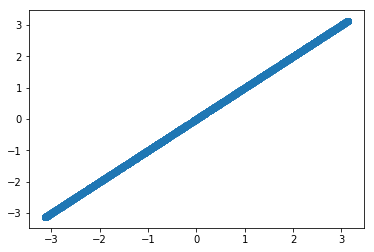

In [52]:
plt.scatter(start_phi, az)

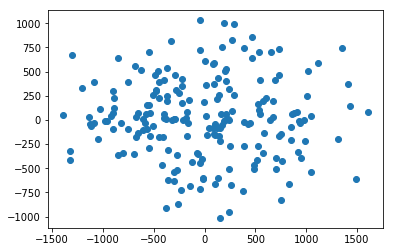

In [55]:
plt.scatter(df.loc[df.magn_len == 10, ]['hit_x'], df.loc[df.magn_len == 10, ]['hit_y'])

(array([16., 32., 34., 31., 30., 34., 25., 29., 30., 32., 33., 29., 24.,
        30., 25., 24., 28., 35., 24., 31., 19., 34., 22., 29., 21., 27.,
        26., 41., 31., 27., 28., 21., 25., 35., 32., 18., 31., 39., 24.,
        39., 23., 39., 26., 23., 35., 25., 31., 40., 26., 16., 29., 20.,
        34., 35., 28., 23., 32., 28., 23., 35., 36., 31., 35., 37., 44.,
        27., 34., 33., 23., 31., 21., 27., 28., 32., 23., 41., 23., 28.,
        32., 28., 31., 24., 26., 46., 20., 27., 29., 35., 29., 22., 23.,
        35., 28., 28., 18., 12., 16., 12.,  2.,  3.]),
 array([0.94452167, 1.03499656, 1.12547145, 1.21594635, 1.30642124,
        1.39689614, 1.48737103, 1.57784592, 1.66832082, 1.75879571,
        1.84927061, 1.9397455 , 2.03022039, 2.12069529, 2.21117018,
        2.30164508, 2.39211997, 2.48259486, 2.57306976, 2.66354465,
        2.75401955, 2.84449444, 2.93496933, 3.02544423, 3.11591912,
        3.20639402, 3.29686891, 3.3873438 , 3.4778187 , 3.56829359,
        3.65876849, 3.7492

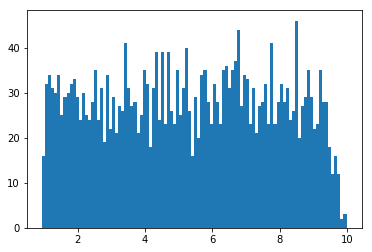

In [57]:
plt.hist(df.start_pz, bins=100)

In [26]:
init_cond = np.c_[np.sqrt(df[['start_px', 'start_py', 'start_pz']].pow(2).sum(axis=1).values), df[['start_theta', 'start_phi', 'magn_len']].values]
result = df[['hit_x', 'hit_y', 'hit_z']].values

In [42]:
init_cond.shape, result.shape

((2796, 6), (2796, 3))

In [43]:
data = np.concatenate([init_cond, result], axis=1)

In [44]:
data = torch.tensor(data).to(device).float()

In [45]:
import math

def standard_normal_logprob(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([
        data[:, 0],
        data[:, 1],
        data[:, 2],
        data[:, 3],
        data[:, 4],
        data[:, 5],
        torch.zeros(len(data)).to(data.device), 
        torch.zeros(len(data)).to(data.device), 
        torch.zeros(len(data)).to(data.device)
    ], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas

def compute_loss(model, data, batch_size=None):
    # load data
    #x = sample_data(data, batch_size=batch_size)
    #x = torch.from_numpy(x).float().to(device)
    # zero = torch.stack([torch.zeros(data.shape[0]).to(data.device), data[:, 1], data[:, 2]], dim=1).float()
    zero = torch.zeros(data.shape[0], 1).to(data.device)
    # print(zero.shape)
    # transform to z
    #zero[:, 2] = data[:, 2].detach()
    z, delta_logp = model(data, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z, data).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

# Defining FFJORD model

In [68]:
regularization_fns = None
#regularization_fns, regularization_coeffs = create_regularization_fns()
model = build_model_tabular(dims=data.shape[1], 
                            num_blocks=1, 
                            hidden_dims=(16, 16), bn_lag=0.1,
                            regularization_fns=regularization_fns).to(device)

In [69]:
from torch.nn.utils import clip_grad_norm
from tqdm import tqdm

In [70]:
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [71]:
model.train();
for i in tqdm(range(40)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    if loss.item() < 4:
        break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    clear_output()
    print(loss_meter.avg, nfe_total)






100%|██████████| 40/40 [07:29<00:00, 20.16s/it]

206248.6073151965 1319.0


In [72]:
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

loss_meter = utils.RunningAverageMeter(0.5)
nfef_meter = utils.RunningAverageMeter(0.5)
nfeb_meter = utils.RunningAverageMeter(0.5)

In [ ]:
model.train();
for i in tqdm(range(300)):
    optimizer.zero_grad()
    
    loss = compute_loss(model, data)

    loss_meter.update(loss.item())
    # nfe_forward = count_nfe(model)

    loss.backward()
    # clip_grad_norm(model.parameters(), 5)
    optimizer.step()
    #if loss.item() < 4:
    #    break
    nfe_total = count_nfe(model)
    # nfe_backward = nfe_total - nfe_forward
    # nfef_meter.update(nfe_forward)
    # nfeb_meter.update(nfe_backward)
    clear_output()
    print(loss_meter.avg, nfe_total)






 38%|███▊      | 113/300 [43:22<1:09:26, 22.28s/it]

14469.723812129087 1391.0


In [74]:
model.eval();

In [75]:
sample_fn, density_fn = get_transforms(model)

# Test on mu outside of training domain

It was trained on $\mu \in [ -30: 30]$ and evaluated on $\mu \in [ -60: 60]$

In [88]:
df['start_theta']

,start_px,start_py,start_pz,pid,hit_x,hit_y,hit_z,magn_len,start_theta,start_phi
0,-0.168032,0.264555,1.997276,13.0,-76.371696,304.602570,-13000.0,1.0,0.155648,2.136661
1,-0.240221,-0.118770,6.208177,13.0,-51.002476,-44.053688,-13000.0,1.0,0.043139,-2.682420
2,0.702783,0.044283,4.929460,13.0,376.157074,20.979713,-13000.0,1.0,0.141891,0.062928
3,0.577812,-1.404743,5.198709,13.0,300.918060,-623.416077,-13000.0,1.0,0.284263,-1.180562
4,0.072576,0.231726,2.408074,13.0,165.932465,222.033234,-13000.0,1.0,0.100498,1.267274
5,0.405773,0.453136,2.046573,13.0,577.063354,513.260681,-13000.0,1.0,0.288895,0.840485
6,0.787532,0.747999,7.747266,13.0,264.953583,222.134720,-13000.0,1.0,0.139289,0.759659
7,0.115675,-0.177540,7.267551,13.0,68.842812,-55.614948,-13000.0,1.0,0.029149,-0.993339
8,-0.034836,-0.649491,5.206270,13.0,29.140882,-286.916870,-13000.0,1.0,0.124287,-1.624381
9,0.005705,0.103684,1.000741,13.0,248.250031,238.894348,-13000.0,1.0,0.103394,1.515828


In [97]:
df.loc[df['magn_len'] == 1.]['hit_x'].mean()

21.544467165470124

In [98]:
df.loc[df['magn_len'] == 1.]['hit_x'].std()

451.4278405373423

In [107]:
df.loc[df['magn_len'] == 1.]['start_phi'].shape

(200,)

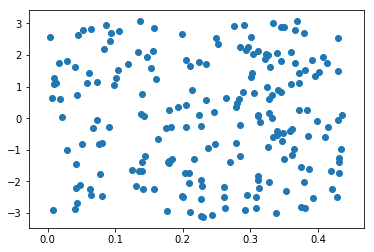

In [106]:
plt.scatter(df.loc[df['magn_len'] == 1.]['start_theta'], df.loc[df['magn_len'] == 1.]['start_phi'])

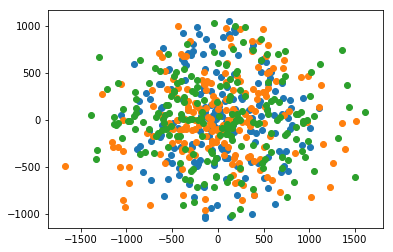

In [105]:
plt.scatter(df.loc[df['magn_len'] == 1.]['hit_x'], df.loc[df['magn_len'] == 1.]['hit_y'])
plt.scatter(df.loc[df['magn_len'] == 5.]['hit_x'], df.loc[df['magn_len'] == 5.]['hit_y'])
plt.scatter(df.loc[df['magn_len'] == 10.]['hit_x'], df.loc[df['magn_len'] == 10.]['hit_y'])

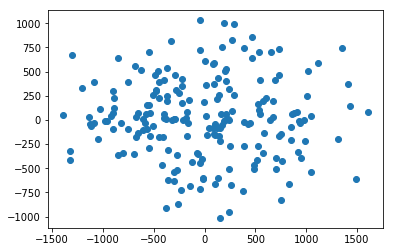

In [99]:
df.loc[df['magn_len'] == 10.]['hit_x'].mean()

-5.060897599512608

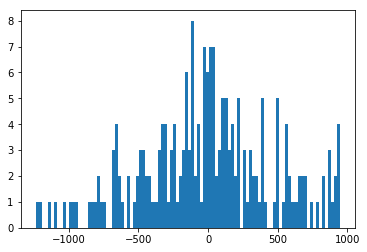

In [94]:
plt.hist(df.loc[df['magn_len'] == 2.]['hit_x'], bins=100);

(array([  14.,   62.,  160.,  313., 1135.,  649.,  293.,  111.,   48.,
          11.]),
 array([-3.85701108, -3.05953829, -2.26206551, -1.46459272, -0.66711993,
         0.13035285,  0.92782564,  1.72529843,  2.52277122,  3.320244  ,
         4.11771679]),
 <a list of 10 Patch objects>)

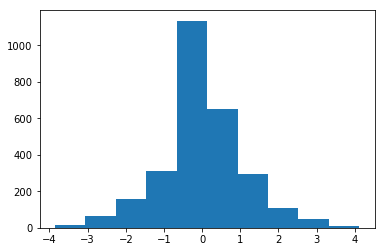

In [82]:
plt.hist(df['start_px'].values)

(array([ 13.,  57., 135., 276., 806., 974., 322., 128.,  58.,  27.]),
 array([-4.01547194, -3.22269123, -2.42991052, -1.63712981, -0.8443491 ,
        -0.05156839,  0.74121232,  1.53399303,  2.32677374,  3.11955445,
         3.91233516]),
 <a list of 10 Patch objects>)

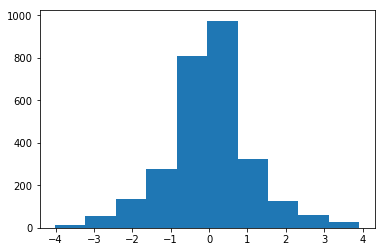

In [83]:
plt.hist(df['start_py'].values)

(array([293., 283., 277., 292., 284., 287., 331., 283., 289., 177.]),
 array([0.94452167, 1.84927061, 2.75401955, 3.65876849, 4.56351743,
        5.46826637, 6.37301531, 7.27776425, 8.18251319, 9.08726213,
        9.99201107]),
 <a list of 10 Patch objects>)

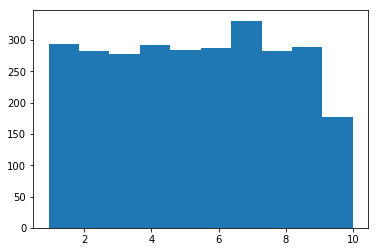

In [84]:
plt.hist(df['start_pz'].values)

In [ ]:
f = plt.figure(figsize=(21,16))
mu_range = list(range(-60, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[::len(mu_range) // 12][i * 3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample()

        input_mu = input_mu.to(device)

        
        data_ref = torch.stack([0.1 * torch.randn(len(input_mu)).to(device), 
                                input_mu, input_x], dim=1).float()
        sampled = sample_fn(data_ref)
        
        
        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(sampled[:, 0].detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))
        
experiment.log_figure(figure_name="FFJOR evaluation", figure=f)

In [ ]:
from scipy.stats import wasserstein_distance, entropy

In [ ]:
from gan.metrics import Metrics

In [ ]:
metric_calc = Metrics((-50, 50), 100)

In [ ]:
f = plt.figure(figsize=(21,16))
mu_range = list(range(-60, 60, 2))
for i in range(4):
    for j in range(3):
        mu = mu_range[::len(mu_range) // 12][i * 3 + j]
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[::len(mu_range) // 12][i * 3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample()

        input_mu = input_mu.to(device)

        
        data_ref = torch.stack([0.1 * torch.randn(len(input_mu)).to(device), 
                                input_mu, input_x], dim=1).float()
        sampled = sample_fn(data_ref)
        
        w_dist = wasserstein_distance(sampled[:, 0].detach().cpu().numpy(), data.detach().cpu().numpy())
        experiment.log_metric('wasserstein_distance_mu={}'.format(mu), w_dist)
        
        for order in [1, 2]:
            diff = metric_calc.compute_moment(sampled[:, 0].cpu().detach(), order=order) - metric_calc.compute_moment(data.cpu().detach(), order=order)
            experiment.log_metric('moment_diff_mu={},order={}'.format(mu, order), diff)
        
        js = metric_calc.compute_JS(sampled[:, 0].cpu(), data.cpu())
        kl = metric_calc.compute_KL(sampled[:, 0].cpu(), data.cpu())
        ksstat = metric_calc.compute_KSStat(sampled[:, 0].cpu().detach(), data.cpu().detach())
        
        experiment.log_metric('JS_mu={}'.format(mu), js)
        experiment.log_metric('KL_mu={}'.format(mu), kl)
        experiment.log_metric('KS_mu={}'.format(mu), ksstat)
        print(mu, w_dist, js, kl, ksstat)

# Density estimation

In [ ]:
from scipy.signal import savgol_filter
def standard_normal_logprob_for_sampling(z, data):
    logZ = -0.5 * math.log(2 * math.pi)
    data_ref = torch.stack([torch.zeros(len(data)).to(data.device), 
                            data[:, 1],
                            data[:, 2]], dim=1).float()
    zpow = (z - data_ref).pow(2)
    sigmas = torch.tensor([1., 1., 1.]).float().to(data.device)
    return logZ - zpow / 2 / sigmas


def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def proba_fn(data_ref, density_fn):
    zero_ref = torch.stack([torch.zeros(len(data_ref)).to(device), 
                            data_ref[:, 1],
                            data_ref[:, 2]], dim=1).float()
    z, delta_logp = density_fn(data_ref, zero_ref)
    logpz = standard_normal_logprob_for_sampling(z, data_ref)
    logpx = logpz - delta_logp
    
    yhat = savgol_filter(logpx.sum(dim=1).detach().cpu().numpy(), 21, 3)
    proba = exp_normalize(yhat)
    return proba

In [ ]:
plt.figure(figsize=(21, 16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4, 3, i*3 + j + 1)
        input_mu = torch.full(size=(100, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        ref = torch.linspace(10, 70, len(input_mu)).float().to(device)
        data_ref = torch.stack([ref, input_mu, input_x], dim=1).float()
        proba = proba_fn(data_ref, density_fn)
        plt.hist(data, bins=100, normed=True, label='true');
        plt.plot(ref.detach().cpu().numpy(), proba / (ref[1] - ref[0]).item(), color='g', alpha=0.5, label='ffjord');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Test optimisation

In [ ]:
lr = 0.1
sample_size = 5


mu_optim = torch.tensor(30.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [ ]:
%%time
n_iter = 3000
losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):    
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update    
    data_ref = torch.stack([torch.randn(len(mu_optim)).to(device), 
                            mu_optim, x], dim=1).float()
    sampled = sample_fn(data_ref)
    
    loss = R(sampled[:, 0])
    losses.append(loss.item())
    if mu_optim.grad is not None: mu_optim.grad.zero_()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())
    clear_output()
    
    print(_iter, mu_optim[0].item())

 24%|██▍       | 722/3000 [21:47<1:14:54,  1.97s/it]

721 -6.486995220184326


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)